# Validation of the Kolmorow Flow solver vis spectrum comparison

The spectrum of the Kolmogow flow at specific Reynolds numbers is known.

This notebook is a Work-in-Progress. So far, I believe that I only considered
the enstrophy spectrum (of the vorticity). Probably, I have to extract the
velocity components out of the vorticity and compute an energy spectrum with
them to correctly compare with, e.g., the Kochkov et al. paper.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
import exponax as ex

In [3]:
L = 2 * jnp.pi
N = 256
DT = 0.01
NUM_SUBSTEPS = 10
Re = 1000

In [4]:
kolm_stepper_1000 = ex.RepeatedStepper(
    ex.stepper.KolmogorovFlowVorticity(
        2,
        L,
        N,
        DT / NUM_SUBSTEPS,
        diffusivity=1 / Re,
    ),
    NUM_SUBSTEPS,
)

2024-09-12 14:47:53.354334: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
ic = ex.ic.DiffusedNoise(2)(N, key=jax.random.PRNGKey(0))

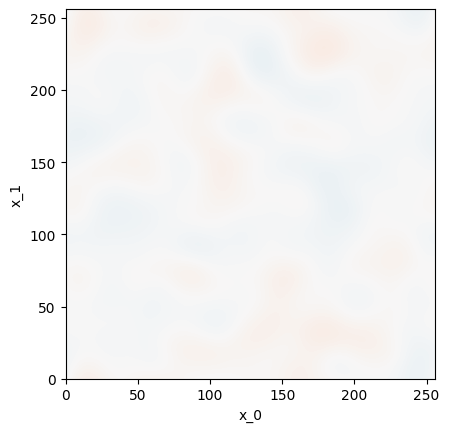

In [6]:
ex.viz.plot_state_2d(ic, vlim=(-1, 1))

In [7]:
# Warmup
warmed_ic_1000 = ex.repeat(kolm_stepper_1000, int(10 / DT))(ic)

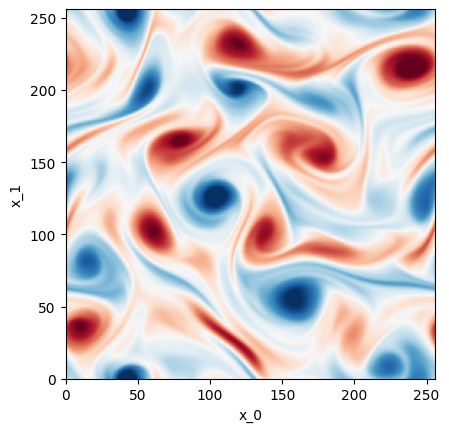

In [8]:
ex.viz.plot_state_2d(warmed_ic_1000, vlim=(-10, 10))

In [9]:
# Create a trajectory for time-averaged statistics
trj_1000 = ex.rollout(kolm_stepper_1000, 1000, include_init=False)(warmed_ic_1000)
trj_1000.shape

(1000, 1, 256, 256)

In [10]:
enstrophy_spectra_1000 = jax.vmap(ex.get_spectrum)(trj_1000)

In [11]:
mean_enstrophy_spectrum_1000 = jnp.mean(enstrophy_spectra_1000, axis=0)

In [12]:
wavenumbers = ex.spectral.build_wavenumbers(1, N)

In [13]:
scaled_enstrophy_spectrum_1000 = mean_enstrophy_spectrum_1000 * wavenumbers**3

In [14]:
scaled_enstrophy_spectrum_1000.shape

(1, 129)

Below is the scaled enstrophy spectrum in a log-log plot. This should match the curve of

    Kochkov, D., Smith, J.A., Alieva, A., Wang, Q., Brenner, M.P. and
    Hoyer, S., 2021. Machine learning–accelerated computational fluid
    dynamics. Proceedings of the National Academy of Sciences, 118(21),
    p.e2101784118.

in Figure 2(c) with resolution 256x256. This Figure displayed the **energy
spectrum** $E(k)$ scaled by $k^5$. Since the relation from entropy spectrum to
enstrophy spectrum is roughly $E(k) = k^2 E_\omega(k)$, the plot below only
scales the enstrophy spectrum by $k^3$.

The order magnitude on the y-axis does not match but this could likely be caused
by two different ways of computing the spectrum (i.e., a different offset).
Qualitatively, the spectra seem somewhat comparable:

- The "linear" slope in the beginnig all the way to peak (given by the energy
    injection mode) is represented
- The "linear" slope spans roughly three orders of magnitude
- Beyond the peak, there is a dip, followed by an almost flat (only small slope)
- However, different from Kochkov et al., the point of inflection beyond the
    spectrum begins its strong decay is not at wavenumber $\approx 13-14$ but
    beyon wavenumber $\approx 30$. I do not have an explanation for this yet,
    but maybe it could be related to comparing enstrophy and energy spectra.

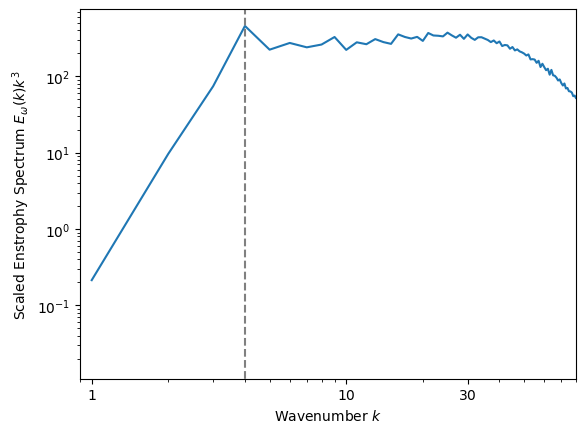

In [15]:
# Not plot the mean mode
plt.loglog(wavenumbers[0, 1:], scaled_enstrophy_spectrum_1000[0, 1:])
plt.xlim(0.9, 80)
plt.ylabel(r"Scaled Enstrophy Spectrum $E_\omega(k) k^3$")
plt.xlabel("Wavenumber $k$")
plt.xticks([1e0, 1e1, 3e1], ["$1$", "$10$", "$30$"])
plt.vlines(4, 1e-3, 1e4, linestyles="--", color="gray")

# At Reynolds number 40 & 100

In [16]:
DT_40 = 0.1
DT_100 = 0.01

In [17]:
kolm_stepper_40 = ex.RepeatedStepper(
    ex.stepper.KolmogorovFlowVorticity(
        2,
        L,
        N,
        DT_40 / NUM_SUBSTEPS,
        diffusivity=1 / 40,
        drag=-0.1,  # No drag
    ),
    NUM_SUBSTEPS,
)

In [18]:
warmed_ic_40 = ex.repeat(kolm_stepper_40, int(500 / DT_40))(ic)

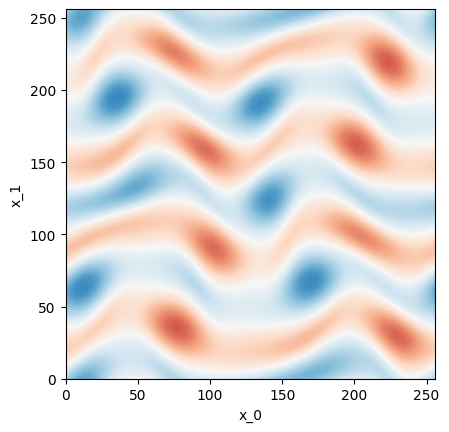

In [19]:
ex.viz.plot_state_2d(warmed_ic_40, vlim=(-10, 10))

In [20]:
kolm_stepper_100 = ex.RepeatedStepper(
    ex.stepper.KolmogorovFlowVorticity(
        2,
        L,
        N,
        DT_100 / NUM_SUBSTEPS,
        diffusivity=1 / 100,
        drag=-0.1,  # No drag
    ),
    NUM_SUBSTEPS,
)

In [21]:
warmed_ic_100 = ex.repeat(kolm_stepper_100, int(100 / DT_100))(ic)

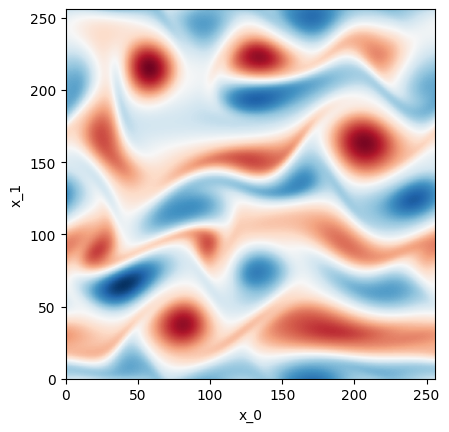

In [22]:
ex.viz.plot_state_2d(warmed_ic_100, vlim=(-10, 10))

In [23]:
trj_40 = ex.rollout(kolm_stepper_40, 1000, include_init=True)(warmed_ic_40)
enstrophy_spectra_40 = jax.vmap(ex.get_spectrum)(trj_40)
mean_enstrophy_spectrum_40 = jnp.mean(enstrophy_spectra_40, axis=0)

In [24]:
trj_100 = ex.rollout(kolm_stepper_100, 1000, include_init=True)(warmed_ic_100)
enstrophy_spectra_100 = jax.vmap(ex.get_spectrum)(trj_100)
mean_enstrophy_spectrum_100 = jnp.mean(enstrophy_spectra_100, axis=0)

Below matches Fig. 6 of

    Chandler, G.J. and Kerswell, R.R. (2013) ‘Invariant recurrent
    solutions embedded in a turbulent two-dimensional Kolmogorov flow’,
    Journal of Fluid Mechanics, 722, pp. 554–595.
    doi:10.1017/jfm.2013.122.

available at https://www.damtp.cam.ac.uk/user/rrk26/Papers/CK13.pdf

Text(0.5, 0, 'Wavenumber $k$')

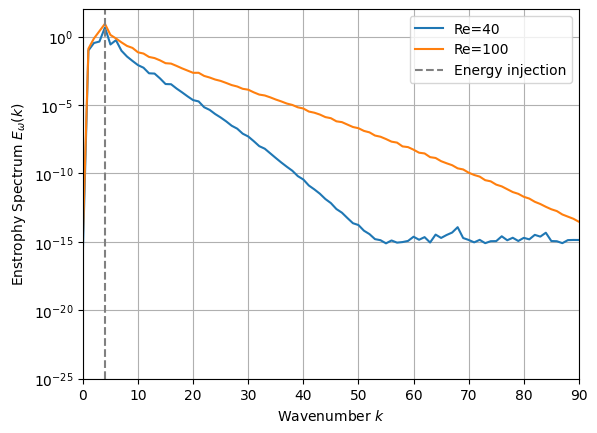

In [25]:
plt.semilogy(mean_enstrophy_spectrum_40[0], label="Re=40")
plt.semilogy(mean_enstrophy_spectrum_100[0], label="Re=100")
plt.vlines(4, 1e-25, 1e2, color="grey", linestyle="--", label="Energy injection")
plt.xlim(0, 90)
plt.ylim(1e-25, 1e2)
plt.yticks(
    [
        1e-25,
        1e-20,
        1e-15,
        1e-10,
        1e-5,
        1e0,
    ]
)
plt.grid()
plt.legend()
plt.ylabel(r"Enstrophy Spectrum $E_\omega(k)$")
plt.xlabel("Wavenumber $k$")